## This Notebook handels the Dualmyo Database 

8 Gestures, 16 Channel-EMG placed on the the wirst and 110 repitions, 5 recordings sessions, 200Hz, 95 synthetic sequences

Each sequence has a lenth of about 50sec (about 10000 timestemps)

https://zenodo.org/record/1320922#.Y9DlgtLMJhE

paper: EMG-based online classification of gestures with recurrent neural networks

In [1]:
"abc"

'abc'

In [1]:
import pickle
import gzip
import os
import numpy as np
import random

In [2]:
path = os.path.abspath("/home/finn/Dokumente/EMG_data/UC2018 DualMyo Hand Gesture Dataset/dualmyo_dataset.pkl")

In [3]:
with open(path, 'rb') as f:
    data = pickle.load(f)

In [4]:
X = data[0]
y = data[1]

In [5]:
len(y)

881

In [6]:
X[0].shape

(400, 20)

In [7]:
sample_data = np.concatenate([sample.reshape((1,) + sample.shape) for sample in X], axis=0)

In [8]:
sample_data.shape

(881, 400, 20)

In [9]:
sample_data[0, :, 0] #what is this for?

array([0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0.,
       0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0.,
       1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1.,
       1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1.,
       2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2.,
       2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2.,
       3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3.,
       3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3.,
       0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0.,
       0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0.,
       1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1.,
       1., 2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1.,
       2., 2., 3., 3., 0., 0., 1., 1., 2., 2., 3., 3., 0., 0., 1., 1., 2.,
       2., 3., 3., 0., 0.

### Plot the EMG Data

In [10]:
import matplotlib.pyplot as plt

In [11]:
plot_data = np.delete(sample_data, [0, 1, 10, 11], axis=2)
plot_data.shape

(881, 400, 16)

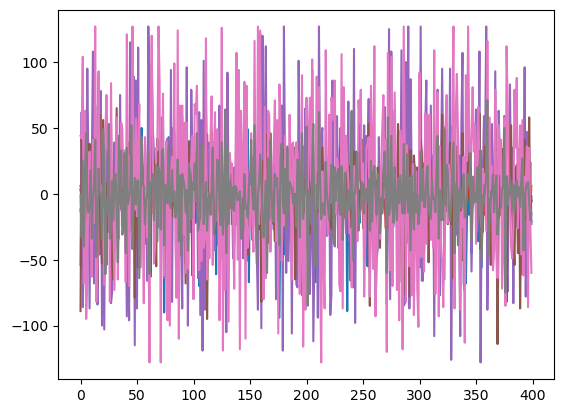

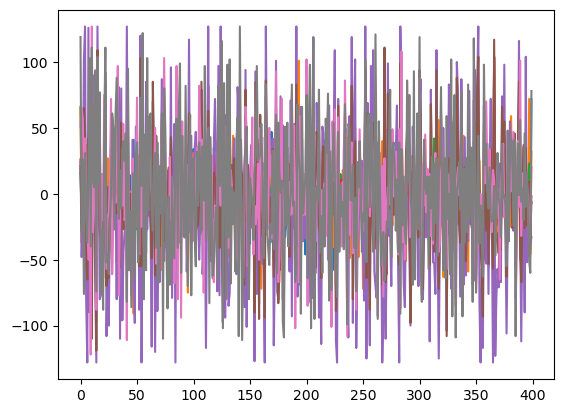

In [12]:
# show EMG plot for different types of gestures 
# plots EMG-Signal of first gesture

gesture = 1

arr = np.unique(y, return_index=True)
index = arr[1][arr[0] == gesture]

plt.plot(plot_data[index[0], :, :8])
plt.show()
plt.plot(plot_data[index[0], :, 8:])
plt.show()

In [13]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([110, 110, 110, 110, 111, 110, 110, 110]))

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# split into train (60%), test (20%) adm val (20%) set
def set_random_params(): 
    np.random.seed(1337)
    random.seed(12345)
    
def split(targets, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    set_random_params()
    ind_all = np.arange(len(targets))
    targets = np.array(targets)
    # Split 1 : all -> train and rest
    sss = StratifiedShuffleSplit(n_splits=1,
                                 test_size=val_ratio+test_ratio,
                                 random_state=42).split(ind_all, targets)
    ind_train, ind_test = next(sss)
    # Split 2 : rest -> val and test
    sss = StratifiedShuffleSplit(n_splits=1,
                                 test_size=(test_ratio/(val_ratio + test_ratio)),
                                 random_state=42).split(ind_test,targets[ind_test])
    ind_val, ind_test = next(sss)
    return ind_train, ind_val, ind_test


set_random_params()
ind_train, ind_val, ind_test = split(y)
y = np.array(y)

In [15]:
x_train, y_train = sample_data[ind_train], y[ind_train]
x_val, y_val = sample_data[ind_val], y[ind_val]
x_test, y_test = sample_data[ind_test], y[ind_test]

In [16]:
# find out where subject is resting and concatenate array
ind_rest = y_train == 0
np.concatenate([sample for sample in x_train[ind_rest]],axis=0).shape

(26400, 20)

In [17]:
y_train.shape

(528,)

### Data Preprocessing

flatten arrays, drop useless cols, feature extraction feature scaling

In [18]:
def flatten_array(samples, targets):
    assert len(samples) == len(targets)
    s, t = [], []
    for target, sample in zip(targets, samples): 
        s.append(sample)
        t.append(np.ones((len(sample), 1)) * target)
    return np.vstack(s), np.vstack(t).reshape(-1)

#x_train, y_train = flatten_array(x_train, y_train)
#x_val, y_val = flatten_array(x_val, y_val)
#x_test, y_test = flatten_array(x_test, y_test)

### Feature Extraction

Window the data and do standard deviation

In [19]:
x_train.shape

(528, 400, 20)

In [20]:
y_train.shape

(528,)

In [21]:
y_train

# maybe rest (0) between two consecutive gestures, since two gestures right after each other doesn't make sense 

array([0, 7, 5, 2, 2, 7, 4, 2, 6, 4, 6, 0, 5, 2, 1, 5, 3, 6, 2, 7, 5, 0,
       5, 2, 7, 1, 4, 4, 5, 0, 7, 7, 2, 6, 3, 7, 5, 1, 0, 5, 0, 2, 5, 1,
       1, 0, 6, 5, 7, 0, 1, 3, 1, 3, 3, 1, 2, 0, 1, 5, 2, 5, 6, 6, 2, 0,
       3, 1, 3, 7, 2, 0, 4, 7, 6, 3, 2, 4, 0, 6, 6, 0, 1, 3, 0, 6, 3, 5,
       6, 4, 5, 0, 7, 3, 6, 0, 2, 0, 3, 1, 0, 5, 5, 0, 6, 3, 0, 3, 3, 5,
       7, 4, 6, 4, 4, 6, 0, 1, 5, 6, 6, 2, 6, 2, 1, 7, 0, 5, 1, 7, 4, 0,
       1, 4, 7, 6, 1, 3, 3, 3, 4, 3, 7, 0, 1, 7, 3, 0, 2, 1, 7, 2, 3, 1,
       1, 5, 4, 4, 1, 1, 3, 6, 7, 1, 5, 7, 2, 3, 6, 3, 5, 4, 0, 0, 6, 2,
       0, 5, 2, 3, 2, 0, 5, 4, 3, 4, 3, 1, 6, 4, 2, 3, 4, 4, 4, 3, 1, 5,
       1, 5, 0, 1, 2, 6, 6, 7, 5, 2, 6, 1, 5, 7, 3, 3, 6, 3, 6, 1, 2, 5,
       1, 0, 1, 2, 3, 5, 2, 4, 6, 7, 6, 7, 3, 5, 2, 2, 1, 7, 7, 7, 7, 0,
       3, 2, 2, 6, 5, 4, 0, 3, 4, 5, 0, 3, 2, 2, 1, 5, 7, 3, 0, 0, 1, 1,
       1, 6, 2, 4, 7, 3, 5, 2, 3, 6, 3, 4, 4, 4, 0, 2, 5, 6, 1, 6, 5, 6,
       6, 5, 5, 2, 4, 4, 2, 7, 7, 2, 7, 6, 1, 5, 5,

for every sample window data like: 400, 20 --> (100, 20), (100, 20), (100, 20), (100, 20)

In [22]:
from numpy.lib.stride_tricks import sliding_window_view

def window_data(array, length=100, overlap=100):
    """ Please make sure sensors are on col, time in row """
    assert array.shape[0]%length == 0
    rows, cols = array.shape
    return sliding_window_view(array,(length, cols))[::overlap, 0]



x_train = np.vstack([window_data(sample) for sample in x_train])
y_train = np.repeat(y_train, 4)

x_test = np.vstack([window_data(sample) for sample in x_test])
y_test = np.repeat(y_test, 4)

x_val = np.vstack([window_data(sample) for sample in x_val])
y_val = np.repeat(y_val, 4)

In [23]:
x_train.shape

(2112, 100, 20)

In [24]:
y_train.shape

(2112,)

In [59]:
# Standard deviation

a = np.array((4, 6, 7, 4, 2, 2))
print(np.sqrt(np.mean((a - np.mean(a))**2)))
np.std(a)

1.863389981249825


1.863389981249825

1.863389981249825


1.863389981249825

In [363]:
def extract_std(array): 
    array = np.delete(array, [0, 1, 10, 11], axis=2)
    return np.std(array, axis=1)

In [364]:
x_train = extract_std(x_train)
x_test = extract_std(x_test)
x_val = extract_std(x_val)

In [366]:
x_train.shape

(2112, 16)

In [367]:
# feature scaling 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [368]:
# one hot encoding 
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
encoder = OneHotEncoder()

encoder.fit(y_train)
y_train = encoder.transform(y_train).toarray()
y_val = encoder.transform(y_val).toarray()
y_test = encoder.transform(y_test).toarray()

y_test.shape

(708, 8)

In [369]:
x_train.shape, y_train.shape

((2112, 16), (2112, 8))

In [370]:
x_train.shape

(2112, 16)

In [371]:
y_train.shape

(2112, 8)

In [372]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(5, algorithm="auto")
model.fit(x_train, y_train)

KNeighborsClassifier()

In [377]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn 
import matplotlib.pyplot as plt

In [382]:
prediction = model.predict(x_test)

prediction, y_test

(array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [383]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1))

0.96045197740113

<AxesSubplot: >

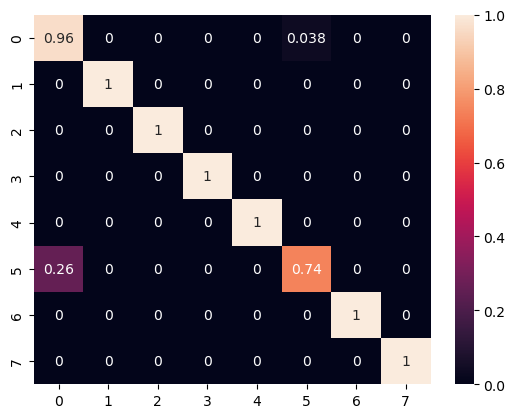

In [375]:
# reverse one-hot-encoding and plot confusion matrix
import seaborn as sn

con_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1), normalize="true")
sn.heatmap(con_mat, annot=True)

### Test different alogrithms 

In [450]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

models = [KNeighborsClassifier(5, algorithm="auto"), 
          SVC(), 
          DecisionTreeClassifier(max_depth=30),
          RandomForestClassifier(max_depth=30, n_estimators=10),
          AdaBoostClassifier(), 
          GaussianNB(), 
          QuadraticDiscriminantAnalysis(), 
          LinearDiscriminantAnalysis(), 
          MLPClassifier(hidden_layer_sizes=(100, 100))
         ]

names = ["KnearestNeigbors", 
         "SVM", 
         "DecisionTree", 
         "RandomForest", 
         "AdaBoost", 
         "Gaussian", 
         "QuadraticDiscriminant", 
         "Linear Discriminant", 
         "MLP"]

one_hot_encoding_needed = [True, False, True, True, False, False, False, False, True]

In [451]:
x_train.shape

(2112, 16)

In [452]:
y_train.shape

(2112, 8)

In [453]:
def reverse_one_hot_encoding(array): 
    return np.argmax(array, axis=1)

for name, model, ohe in zip(names, models, one_hot_encoding_needed): 
    print(name)
    if ohe: 
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)
        print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1)))
    else: 
        model.fit(x_train, np.argmax(y_train, axis=1))
        prediction = model.predict(x_test)
        print(accuracy_score(np.argmax(y_test, axis=1), prediction))
                  

KnearestNeigbors
0.96045197740113
SVM
0.9505649717514124
DecisionTree
0.9745762711864406
RandomForest
0.9731638418079096
AdaBoost
0.4350282485875706
Gaussian
0.9491525423728814
QuadraticDiscriminant
0.9491525423728814
Linear Discriminant
0.9265536723163842
MLP
0.96045197740113
